Exploratory Data Analysis 

In [3]:
import os, re, configparser
import pandas as pd
import numpy as np
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table, show_table
from utilities_analysis import mean_calculator, limits_generator, ini_generator, RyR, z_score_filter, reset_df, style_dataframe
from utilities_plotting import plot_scatter, plot_control_chart, plot_capability, plot_boxplot, df_to_pdf, plot_to_pdf
from utilities_widgets import position_chart
from utilities_IO import output_html
import ipywidgets as widgets
from ipywidgets import HBox
import _db_tools as db
##Widgets creation
fiber_selection = widgets.Text(value='Guia_Luz_Blanco_FB1_X', placeholder='Type the fiber label', description='Fiber label:', disabled=False)
auto_position = widgets.Checkbox(value=True, description='Auto position', layout={'width': '200px'})
mean_slider = widgets.FloatSlider(value=0.35, min=0.3, max=0.4, step=0.0005, readout_format='.3f', description='Y-axis mean')
range_slider = widgets.IntSlider(value=5, min=1, max=10, step=1, description='Y-axis zoom')

In [4]:
##Database access
table_list = consult_database("input.db", verbose=False)
try: #Tries to find a table for the fixture data
    fixture_data = consult_database("input.db", verbose=False, filter="_FixtureData_")[-1]
    file = '_'.join(fixture_data.split("_")[:-7])
except: #Resorts to using globals values
    file = re.sub(r'\W', '_', glob.tooling)
try: #Tries to search for the last tables related to the fixture data
    default_measurements = consult_database("input.db", verbose=False, filter=file+"_Measurements_")[-1]
    default_limits = consult_database("input.db", verbose=False, filter=file+"_Limits_")[-1]
except Exception as e:
    raise Exception("Missing the required tables. Ensure you have the required tables.")
try: #Tries to find a table for the fixture data to compose
    value=(default_measurements, default_limits, fixture_data)
except:
    value=(default_measurements, default_limits)
tables = widgets.SelectMultiple(options=table_list, value=value, description='input db', rows=10, layout={'width': '600px'})

In [5]:
##Data extraction
print('Select the tables to load with "CTRL" or "SHIFT" pressed:')
display(tables)
MEAS = retrieve_data("input.db", next((string for string in tables.value if "Measurements" in string), None))
LIMITS = retrieve_data("input.db", next((string for string in tables.value if "Limits" in string), None))
FIXTURE_DATA = retrieve_data("input.db", next((string for string in tables.value if "FixtureData" in string), None), index_col="index")
if MEAS is None or MEAS.empty or LIMITS is None or LIMITS.empty:
    print("WARNING: Some data might not be correctly retrieved. Check the selected tables")

Select the tables to load with "CTRL" or "SHIFT" pressed:


SelectMultiple(description='input db', index=(2, 1, 0), layout=Layout(width='600px'), options=('PASSAT_B9_Fixt…

Table *PASSAT_B9_Measurements_2024y_08m_09d_11h_46m_41s* retrieved succesfully.
Table *PASSAT_B9_Limits_2024y_08m_09d_11h_46m_41s* retrieved succesfully.
Table *PASSAT_B9_FixtureData_2024y_09m_05d_23h_46m_56s* retrieved succesfully.


In [6]:
##Database management
print(f"File(s) ready to use:")
for table in tables.value:
    print(f"    {table}")

File(s) ready to use:
    PASSAT_B9_Measurements_2024y_08m_09d_11h_46m_41s
    PASSAT_B9_Limits_2024y_08m_09d_11h_46m_41s
    PASSAT_B9_FixtureData_2024y_09m_05d_23h_46m_56s


In [7]:
#Fixture metadata preparation
if "FIXTURE_DATA" not in globals(): #Gets data directly from the globals file
    FIXTURE_DATA = pd.DataFrame.from_records([glob.__dict__]).transpose()
    FIXTURE_DATA.rename(columns={0:"Tooling data"}, inplace=True)
    FIXTURE_DATA.rename(index={"tooling": "Tooling name", "lenses_per_nest": "Lenses per nest", "nests_number": "Number of nests", "x_tolerance":"X-axis tolerance",
                            "y_tolerance":"Y-axis tolerance", "lo_tolerance":"Lower tolerance", "hi_tolerance": "Higher tolerance"}, inplace=True)
print("Fixture metadata:")
display(FIXTURE_DATA)

Fixture metadata:


,Tooling data
Tooling name,PASSAT_B9
Lenses per nest,3
Number of nests,4
X-axis tolerance,0.0125
Y-axis tolerance,0.0165
Lower tolerance,0.02
Higher tolerance,0.03


In [8]:
##Measurements preparation
MEAS_format = rename_index(MEAS)
new_column_names = {old_col: f"test: {i+1}" for i, old_col in enumerate(MEAS_format.columns)}
MEAS_format.rename(columns=new_column_names, inplace=True)
##Measurements review
print("Measurements:")
display(MEAS_format)

Measurements:


,test: 1,test: 2,test: 3,test: 4,test: 5,test: 6,test: 7,test: 8,test: 9,test: 10,...,test: 21,test: 22,test: 23,test: 24,test: 25,test: 26,test: 27,test: 28,test: 29,test: 30
Guia_Luz_Blanco_FB1_X,0.3326,0.3335,0.3335,0.3335,0.3350,0.3350,0.3350,0.0000,0.3350,0.0000,...,0.3344,0.3343,0.3354,0.3308,0.3331,0.3332,0.3331,0.3309,0.3350,0.3312
Guia_Luz_Blanco_FB1_Y,0.3559,0.3561,0.3563,0.3563,0.3576,0.3575,0.3575,0.0000,0.3575,0.0000,...,0.3576,0.3576,0.3577,0.3546,0.3562,0.3561,0.3561,0.3546,0.3575,0.3548
Guia_Luz_Blanco_FB2_X,0.3298,0.3286,0.3268,0.3285,0.3307,0.3309,0.3304,0.0000,0.3303,0.0000,...,0.3304,0.3303,0.3274,0.3280,0.3277,0.3284,0.3276,0.3277,0.3299,0.3268
Guia_Luz_Blanco_FB2_Y,0.3553,0.3547,0.3542,0.3546,0.3559,0.3559,0.3554,0.0000,0.3556,0.0000,...,0.3554,0.3555,0.3540,0.3544,0.3543,0.3547,0.3543,0.3543,0.3556,0.3542
Guia_Luz_Blanco_FB3_X,0.3296,0.3307,0.3305,0.3320,0.3306,0.3292,0.3296,0.0000,0.3296,0.0000,...,0.3302,0.3296,0.3277,0.3313,0.3310,0.3307,0.3313,0.3319,0.3298,0.3307
Guia_Luz_Blanco_FB3_Y,0.3347,0.3349,0.3348,0.3355,0.3353,0.3346,0.3347,0.0000,0.3341,0.0000,...,0.3351,0.3347,0.3345,0.3349,0.3350,0.3349,0.3349,0.3354,0.3340,0.3347
Guia_Luz_Blanco_FB4_X,0.3266,0.3280,0.3272,0.3266,0.3260,0.3266,0.3265,0.0000,0.3250,0.0000,...,0.3272,0.3255,0.3278,0.3282,0.3278,0.3297,0.3276,0.3300,0.3257,0.3287
Guia_Luz_Blanco_FB4_Y,0.3530,0.3534,0.3535,0.3530,0.3526,0.3530,0.3528,0.0000,0.3518,0.0000,...,0.3529,0.3517,0.3539,0.3538,0.3539,0.3552,0.3542,0.3554,0.3519,0.3547
Guia_Luz_Blanco_FB5_X,0.3331,0.3331,0.3329,0.3326,0.3325,0.3330,0.3341,0.0000,0.3311,0.0000,...,0.3336,0.3338,0.3319,0.3323,0.3321,0.3324,0.3333,0.3333,0.3336,0.3321
Guia_Luz_Blanco_FB5_Y,0.3556,0.3558,0.3556,0.3557,0.3555,0.3549,0.3554,0.0000,0.3561,0.0000,...,0.3554,0.3554,0.3547,0.3552,0.3549,0.3551,0.3558,0.3559,0.3557,0.3549


In [41]:
##Limits preparation
LIMITS_format = rename_index(LIMITS)
LIMITS_format.columns = ['LO_LIMIT', 'HI_LIMIT']
print("Limits:")
display(LIMITS_format)

Limits:


,LO_LIMIT,HI_LIMIT
Guia_Luz_Blanco_FB1_X,0.310,0.335
Guia_Luz_Blanco_FB1_Y,0.325,0.358
Guia_Luz_Blanco_FB2_X,0.310,0.335
Guia_Luz_Blanco_FB2_Y,0.325,0.358
Guia_Luz_Blanco_FB3_X,0.325,0.345
Guia_Luz_Blanco_FB3_Y,0.340,0.368
Guia_Luz_Blanco_FB4_X,0.310,0.335
Guia_Luz_Blanco_FB4_Y,0.325,0.358
Guia_Luz_Blanco_FB5_X,0.310,0.335
Guia_Luz_Blanco_FB5_Y,0.325,0.358


In [42]:
##Test results visualization
DATA_format = pd.concat([MEAS_format, LIMITS_format], axis=1)
DATA_FILTERED = style_dataframe(DATA_format, LIMITS_format) # Apply conditional formatting with row-specific limits
display(DATA_FILTERED)

,test: 1,test: 2,test: 3,test: 4,test: 5,test: 6,test: 7,test: 8,test: 9,test: 10,test: 11,test: 12,test: 13,test: 14,test: 15,test: 16,test: 17,test: 18,test: 19,test: 20,test: 21,test: 22,test: 23,test: 24,test: 25,LO_LIMIT,HI_LIMIT
Guia_Luz_Blanco_FB1_X,0.324100,0.327900,0.341100,0.325800,0.325800,0.337200,0.324700,0.335100,0.324600,0.329800,0.330600,0.328400,0.335600,0.327700,0.326400,0.329500,0.329600,0.329900,0.325800,0.334400,0.325200,0.324000,0.341000,0.326400,0.327400,0.310000,0.335000
Guia_Luz_Blanco_FB1_Y,0.353200,0.356300,0.359000,0.354600,0.354300,0.357900,0.354400,0.357700,0.354600,0.356100,0.357500,0.355700,0.357700,0.355900,0.355600,0.355900,0.356100,0.356100,0.354500,0.357300,0.354500,0.353500,0.359200,0.354600,0.355400,0.325000,0.358000
Guia_Luz_Blanco_FB2_X,0.329900,0.330300,0.333400,0.330000,0.329900,0.333500,0.330600,0.332200,0.330500,0.331100,0.331600,0.330600,0.332700,0.330800,0.330600,0.331500,0.331100,0.330800,0.330400,0.332300,0.330700,0.330500,0.333700,0.330400,0.330600,0.310000,0.335000
Guia_Luz_Blanco_FB2_Y,0.356500,0.356900,0.357400,0.356500,0.356400,0.357800,0.357000,0.357500,0.357000,0.357100,0.357200,0.356800,0.357600,0.357100,0.357100,0.357300,0.357100,0.356900,0.356900,0.357400,0.357100,0.356900,0.357700,0.356800,0.357000,0.325000,0.358000
Guia_Luz_Blanco_FB3_X,0.342800,0.342600,0.341500,0.341300,0.344000,0.342600,0.342600,0.342200,0.342000,0.341100,0.341500,0.342600,0.342000,0.342600,0.342600,0.342600,0.343400,0.343300,0.343300,0.342500,0.342600,0.341300,0.343300,0.340900,0.342800,0.325000,0.345000
Guia_Luz_Blanco_FB3_Y,0.368900,0.369100,0.367900,0.367900,0.369800,0.369100,0.369100,0.368200,0.368700,0.367600,0.367800,0.368600,0.368700,0.369100,0.369100,0.369100,0.369100,0.369200,0.369200,0.369200,0.369100,0.367800,0.369200,0.367700,0.368900,0.340000,0.368000
Guia_Luz_Blanco_FB4_X,0.328600,0.331500,0.339100,0.330400,0.328700,0.337300,0.326900,0.339100,0.328800,0.329600,0.330800,0.327200,0.336400,0.328500,0.327800,0.330200,0.329200,0.329400,0.330100,0.328600,0.328000,0.327300,0.337300,0.326800,0.327300,0.310000,0.335000
Guia_Luz_Blanco_FB4_Y,0.355000,0.355800,0.357700,0.355600,0.355000,0.357200,0.354700,0.357500,0.355200,0.355300,0.355400,0.354900,0.356500,0.355100,0.354900,0.355200,0.355000,0.355000,0.355200,0.355000,0.354900,0.354700,0.356500,0.354500,0.354800,0.325000,0.358000
Guia_Luz_Blanco_FB5_X,0.333000,0.333300,0.334700,0.333300,0.332900,0.334700,0.332600,0.334300,0.333100,0.333000,0.333700,0.332700,0.334200,0.332900,0.333100,0.333100,0.333200,0.333100,0.333100,0.333200,0.333200,0.332900,0.333700,0.332900,0.332900,0.310000,0.335000
Guia_Luz_Blanco_FB5_Y,0.360100,0.360100,0.360400,0.360100,0.359900,0.360300,0.359700,0.360300,0.360100,0.359900,0.360100,0.359800,0.360300,0.359800,0.360000,0.360000,0.360000,0.360000,0.360000,0.360100,0.360000,0.360000,0.360100,0.360000,0.359900,0.325000,0.358000


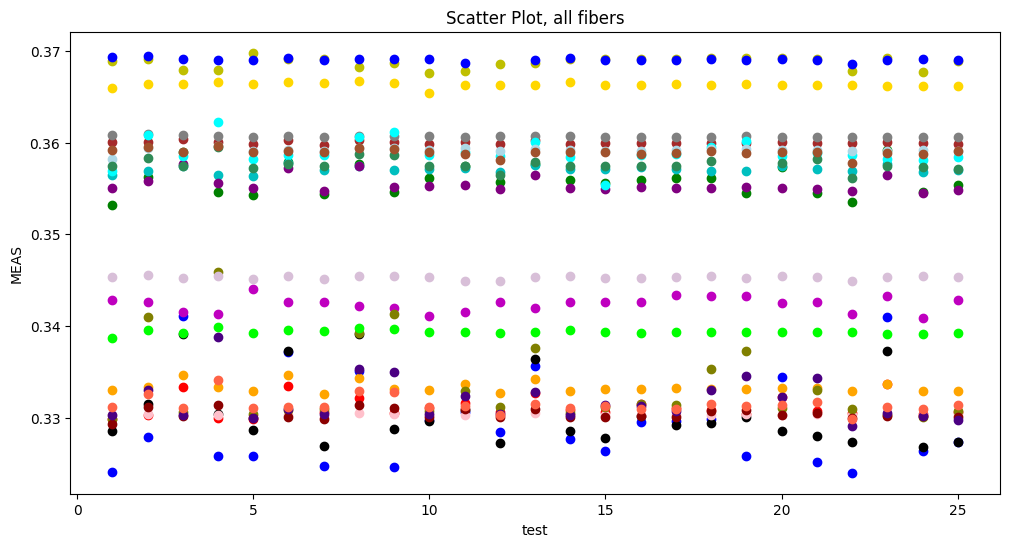

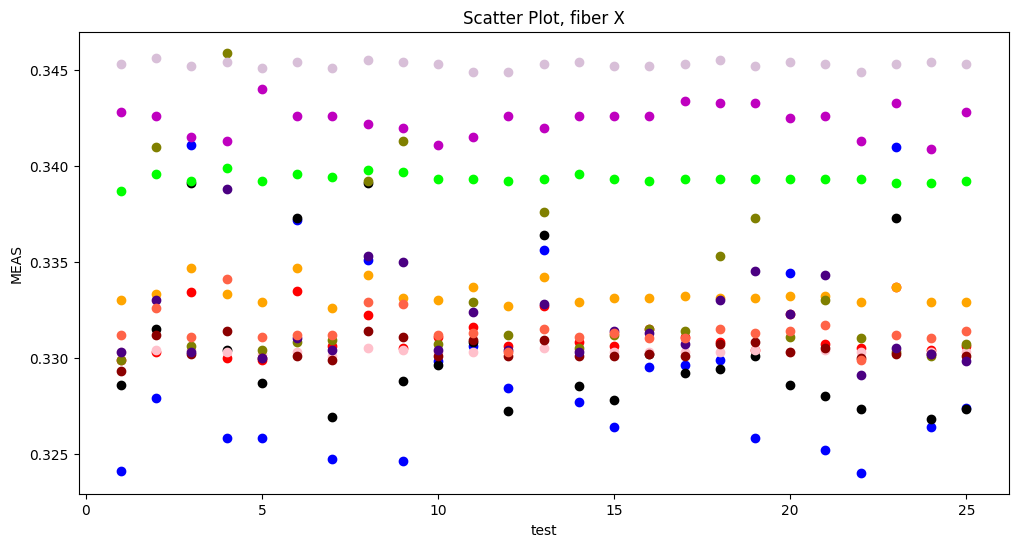

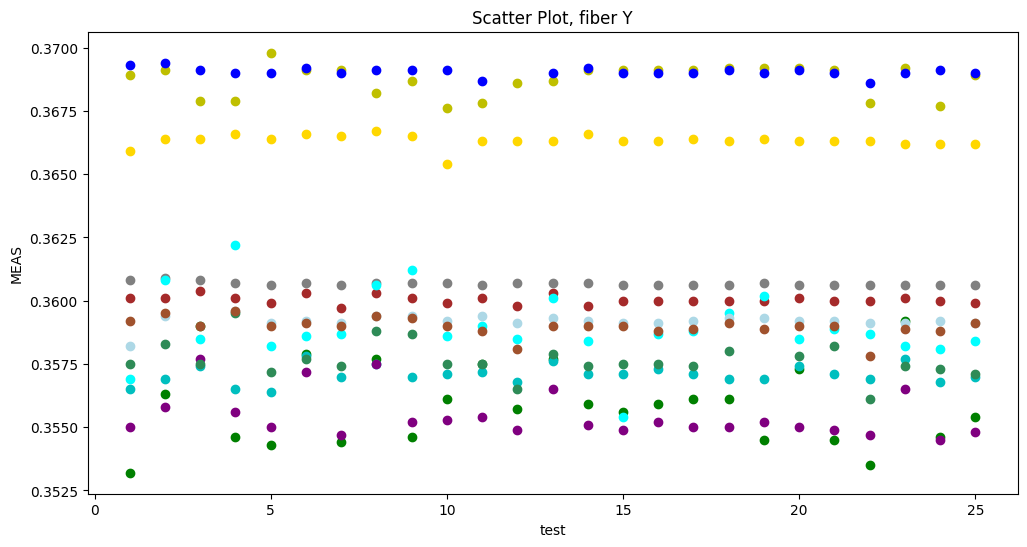

In [43]:
##Visualizations
fig = plot_scatter(MEAS, title='Scatter Plot, all fibers', xlabel='test', ylabel='MEAS') #Plot all guides
fig = plot_scatter(MEAS, title='Scatter Plot, fiber X', xlabel='test', ylabel='MEAS', filter='x') #Plot x axis values
fig = plot_scatter(MEAS, title='Scatter Plot, fiber Y', xlabel='test', ylabel='MEAS', filter='y') #Plot y axis values

In [9]:
##Descriptive statistics
RESUME = MEAS.transpose().describe().transpose() #Transpose the df first due to describe() working in columns.
RESUME_format = rename_index(RESUME)
display(RESUME_format)

,count,mean,std,min,25%,50%,75%,max
Guia_Luz_Blanco_FB1_X,30.0,0.311660,0.084728,0.0000,0.333100,0.33430,0.335000,0.3354
Guia_Luz_Blanco_FB1_Y,30.0,0.333057,0.090540,0.0000,0.356100,0.35750,0.357600,0.3577
Guia_Luz_Blanco_FB2_X,30.0,0.307467,0.083589,0.0000,0.327775,0.32995,0.330400,0.3309
Guia_Luz_Blanco_FB2_Y,30.0,0.331490,0.090111,0.0000,0.354325,0.35540,0.355600,0.3561
Guia_Luz_Blanco_FB3_X,30.0,0.308150,0.083769,0.0000,0.329600,0.33010,0.330675,0.3320
Guia_Luz_Blanco_FB3_Y,30.0,0.312527,0.084955,0.0000,0.334600,0.33485,0.335075,0.3355
Guia_Luz_Blanco_FB4_X,30.0,0.305377,0.083017,0.0000,0.326600,0.32720,0.327675,0.3300
Guia_Luz_Blanco_FB4_Y,30.0,0.329673,0.089619,0.0000,0.352900,0.35295,0.353475,0.3554
Guia_Luz_Blanco_FB5_X,30.0,0.310760,0.084477,0.0000,0.332325,0.33305,0.333600,0.3341
Guia_Luz_Blanco_FB5_Y,30.0,0.331690,0.090164,0.0000,0.355125,0.35540,0.355575,0.3561


Analysis of faulty fibers

In [45]:
##Analysis of faulty fibers
std = pd.DataFrame(RESUME_format['std'])  #Get the std values
fiber_number = rename_index(pd.DataFrame(range(1, std.shape[0]+1))).rename(columns={0: 'Fiber number'}) #Adds an absolute fiber number for quick identification
LARGEST = pd.concat([std, fiber_number], axis = 1).sort_values(by="std", ascending=False)[:5]  #Filters the 5 largest values
display(LARGEST)

,std,Fiber number
Guia_Luz_Blanco_FB1_X,0.005070,1
Guia_Luz_Blanco_FB7_X,0.004382,13
Guia_Luz_Blanco_FB4_X,0.003921,7
Guia_Luz_Blanco_FB10_X,0.002263,19
Guia_Luz_Blanco_FB1_Y,0.001620,2


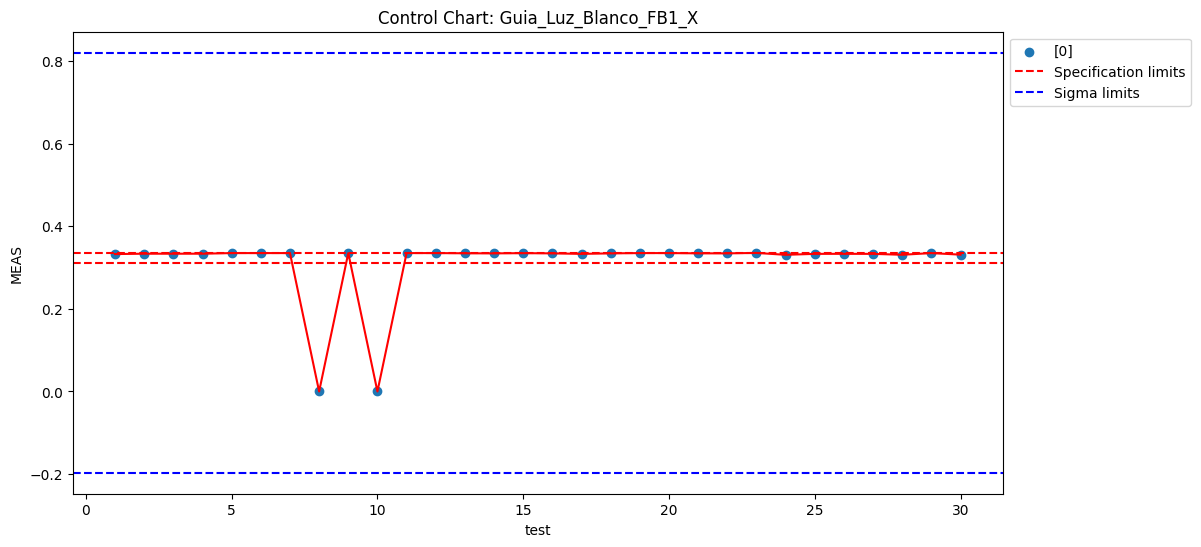

In [10]:
##Specific fibers visualization
yrange = position_chart(mean_slider, range_slider, auto_position_flag=auto_position.value)
display(HBox([fiber_selection, auto_position, mean_slider, range_slider]))
plot_control_chart(MEAS_format, title=f'Control Chart: {fiber_selection.value}', xlabel='test', ylabel='MEAS', LIMITS=LIMITS, fiber=fiber_selection.value, yrange=yrange)

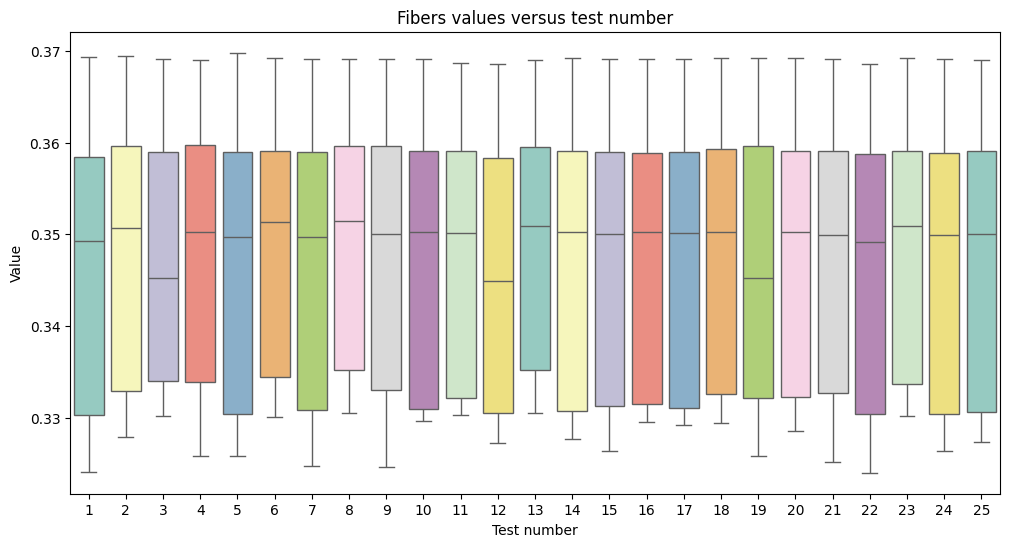

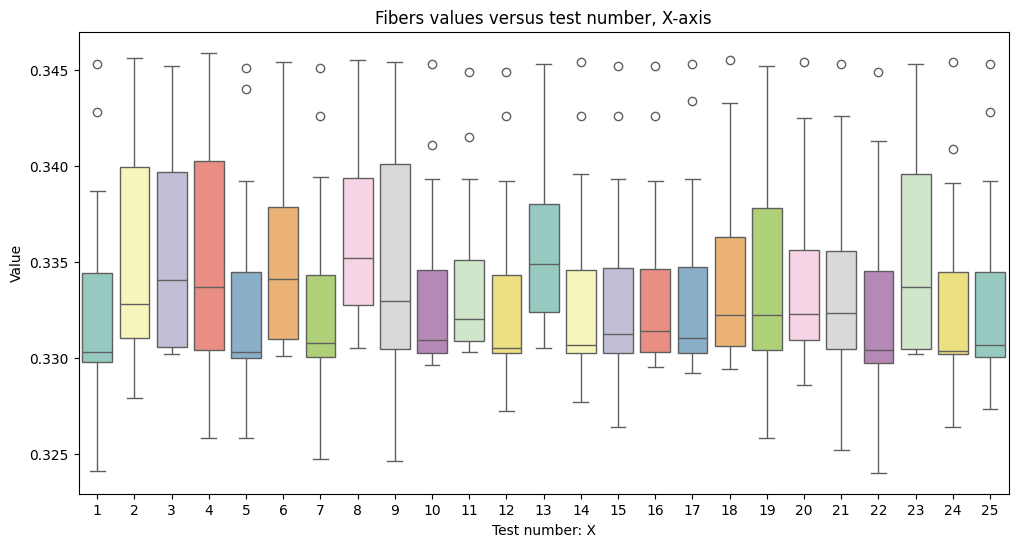

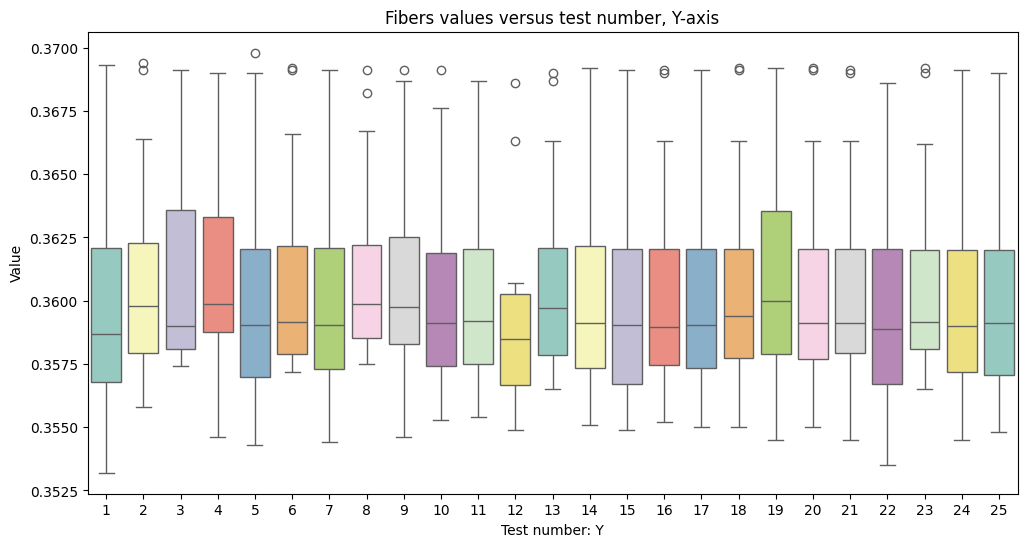

In [46]:
##Boxplot visualization
fig = plot_boxplot(MEAS_format, title="Fibers values versus test number", xlabel="Test number", ylabel="Value", filter=None)
fig = plot_boxplot(MEAS_format, title="Fibers values versus test number, X-axis", xlabel="Test number: ", ylabel="Value", filter="X")
fig = plot_boxplot(MEAS_format, title="Fibers values versus test number, Y-axis", xlabel="Test number: ", ylabel="Value", filter="Y")
#fig = plot_boxplot(MEAS_format, title="Fibers comparison, X-axis", xlabel="Test number: ", ylabel="Value", filter="X", lenses_per_nest=int(FIXTURE_DATA.loc["Lenses per nest", "Tooling data"]))

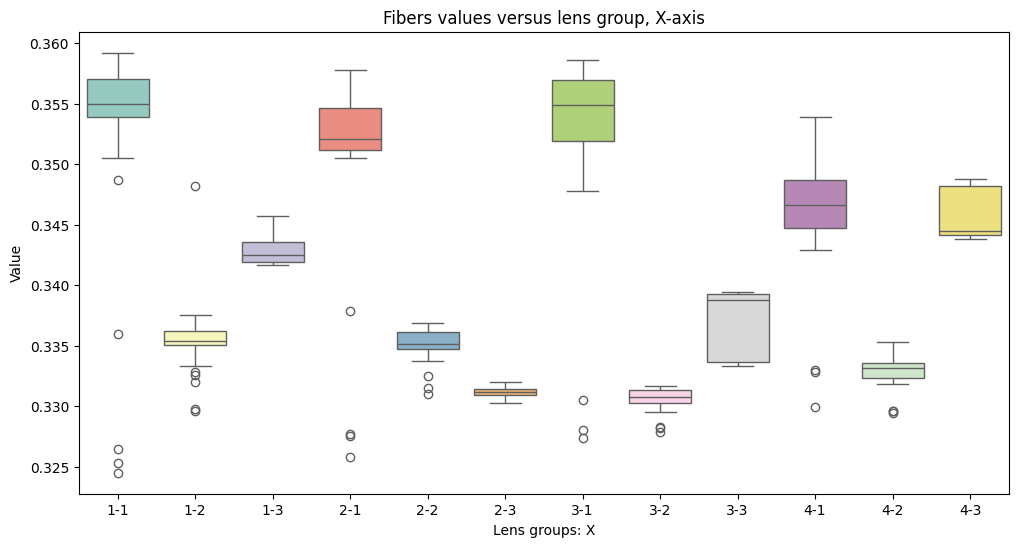

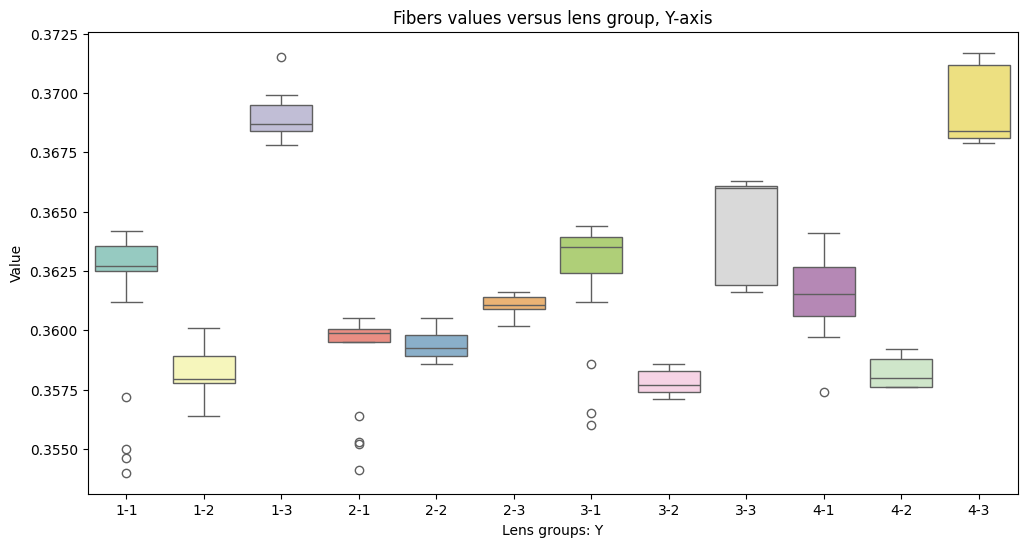

In [16]:
fig = plot_boxplot(MEAS_format.transpose(), title="Fibers values versus lens group, X-axis", xlabel="Lens groups: ", ylabel="Value", filter="X", lenses_per_nest=int(FIXTURE_DATA.loc["Lenses per nest", "Tooling data"]))
fig = plot_boxplot(MEAS_format.transpose(), title="Fibers values versus lens group, Y-axis", xlabel="Lens groups: ", ylabel="Value", filter="Y", lenses_per_nest=int(FIXTURE_DATA.loc["Lenses per nest", "Tooling data"]))

In [22]:
######Terminar
##Data export
date = get_date()
name_xlsx = glob.tooling + "_EDA_" + get_date() + ".xlsx"
name_scatter = FIXTURE_DATA.loc["Tooling name", "Tooling data"] + "_EDA_scatter_" + date + ".pdf"
name_bloxplot = FIXTURE_DATA.loc["Tooling name", "Tooling data"] + "_EDA_boxplot_" + date + ".pdf"
confirmation = input("Do you want to export the data? (y/n): ").strip().lower()
if confirmation == 'y':
    output_filepath = os.path.abspath("../a2_output/reports")
    DATA = pd.concat([MEAS_format, LIMITS_format], axis=1)
    plot_to_pdf(MEAS, name=name_scatter, plot="SCATTER")
    plot_to_pdf([MEAS_format, FIXTURE_DATA], name=name_bloxplot, plot="BOXPLOT")
    output_html([FIXTURE_DATA, MEAS_format, LIMITS_format, RESUME_format, LARGEST, DATA_FILTERED], "EDA.html")
    output_html([DATA_FILTERED], "Values.html")
    print(f'Analysis data and visualizations exported inside:\n{os.path.split(output_filepath)[0]}')
else:
    print("Operation canceled.")

Analysis data and visualizations exported inside:
c:\Codebase\Python_Eiit_RyR\a2_Analyser\a2_output
